In [1]:
import sys
import torch
from d2l import torch as d2l
import torchvision
from torch.utils import data
from torchvision import transforms
d2l.use_svg_display

<function d2l.torch.use_svg_display()>

In [5]:
trans=transforms.ToTensor()#将数据转化为tensor张量格式
mnist_train=torchvision.datasets.FashionMNIST(#torchvison内置函数将fashion_mnist数据下载到读取到内存中，位置为root
    root='./data2', train=True, transform=trans,download=True
)
mnist_test=torchvision.datasets.FashionMNIST(
    root='./data2',train=False,transform=trans,download=True
)

100%|██████████| 26421880/26421880 [00:26<00:00, 991620.92it/s] 


Extracting ./data2/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data2/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 109852.71it/s]


Extracting ./data2/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data2/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:03<00:00, 1331913.89it/s]


Extracting ./data2/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data2/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6188672.11it/s]

Extracting ./data2/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data2/FashionMNIST/raw



In [6]:
len(mnist_train),len(mnist_test)

(60000, 10000)

In [7]:
mnist_train[0][0].shape#每个图像的形状，数据集由灰度图像组成，通道数为1，高宽皆为28

torch.Size([1, 28, 28])

In [10]:

# 以下函数用于在数字标签索引及其文本名称之间进行转换返回对应的标签名
def get_fashion_mnist_labels(labels):
    # Fashion-MNIST中包含的10个类别，分别为t-shirt（T恤）、trouser（裤子）、pullover（套衫）、dress（连衣裙）、
    # coat（外套）、sandal（凉鞋）、shirt（衬衫）、sneaker（运动鞋）、bag（包）和ankle boot（短靴）。
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)]for i in labels]



In [25]:
#传入所有图像进行绘制
def show_images(imgs,num_rows,num_cols,titles=None,scale=1.5):
    figsize=(num_cols*scale,num_rows*scale)
    # 返回一个fig对象和包含所有子图对象一个axes二维数组（图像窗口长度为num_rows，宽度为num_cols）
    _,axes=d2l.plt.subplots(num_rows,num_cols,figsize=figsize)
    # 将二维数组平铺转化为一维数组方便后续迭代所有子图（为了按顺序迭代，每个元素都是一个子图）
    axes=axes.flatten()
    #zip将（axes,imgs）转化为元组
    #enumerate将对象组合为一个索引序列
    for i,(ax,img)in enumerate(zip(axes,imgs)):
        if torch.is_tensor(img):
            ax.imshow(img.numpy())
        else:
            ax.imshow(img)
    
        #获取x，y坐标轴并隐藏
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

array([<AxesSubplot: title={'center': 'ankle boot'}>,
       <AxesSubplot: title={'center': 't-shirt'}>,
       <AxesSubplot: title={'center': 't-shirt'}>,
       <AxesSubplot: title={'center': 'dress'}>,
       <AxesSubplot: title={'center': 't-shirt'}>,
       <AxesSubplot: title={'center': 'pullover'}>,
       <AxesSubplot: title={'center': 'sneaker'}>,
       <AxesSubplot: title={'center': 'pullover'}>,
       <AxesSubplot: title={'center': 'sandal'}>,
       <AxesSubplot: title={'center': 'sandal'}>,
       <AxesSubplot: title={'center': 't-shirt'}>,
       <AxesSubplot: title={'center': 'ankle boot'}>,
       <AxesSubplot: title={'center': 'sandal'}>,
       <AxesSubplot: title={'center': 'sandal'}>,
       <AxesSubplot: title={'center': 'sneaker'}>,
       <AxesSubplot: title={'center': 'ankle boot'}>,
       <AxesSubplot: title={'center': 'trouser'}>,
       <AxesSubplot: title={'center': 't-shirt'}>], dtype=object)

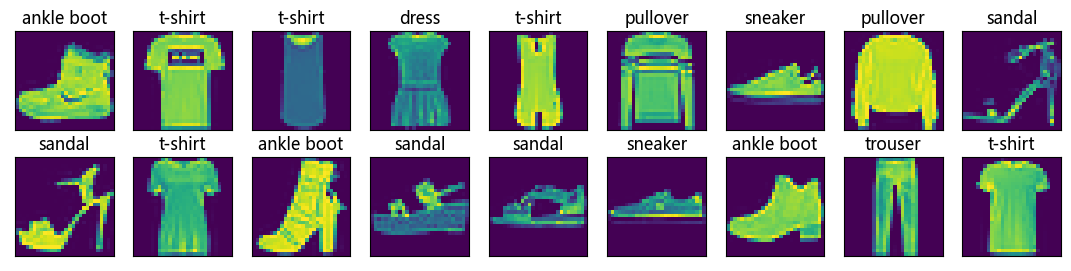

In [26]:
x,y=next(iter(data.DataLoader(mnist_train,batch_size=18)))#
show_images(x.reshape(18,28,28),2,9,titles=get_fashion_mnist_labels(y))#展示包含18张图片的x张量，其中x的形状为（18，784）所以要转化为（18，28，28）
#使每个样本都能被视为28*28的图像

In [24]:
batch_size=256#batch_size 表示深度学习中模型每次训练一次性处理的样本数


def get_dataloader_workers():  # data.DataLoader读取数据使用的进程数 非win一般是4，win一般0（因为不支持多进程加载数据，由主进程读取数据）
    return 4
train_iter=data.DataLoader(mnist_train,batch_size,shuffle=True,num_workers=get_dataloader_workers())
timer=d2l.Timer()
for x,y in train_iter:#对数据集进行了一次遍历，看是否能正常读取每个batch_size的数据，确定是否符合模型的输入要求（为了之后训练高效读取）
    continue
f'{timer.stop():.2f}sec'

'7.19sec'

In [29]:
def load_data_fashion_mnist(batch_size,resize=None):
    # 这是一个数据预处理的列表 ，transforms.ToTensor()将PIL图像或numpy数组数据转化为张量并归一化到0-1
    trans=[transforms.ToTensor()]
    if resize:
        #trans列表首位加入了改变形状的操作，预处理的列表里就包括了改变形状，转为张量两类操作
        trans.insert(0,transforms.Resize(resize))
    trans = transforms.Compose(trans)  # 接收列表类型,将列表中的数据预处理操作转化为一个操作序列方便后续直接调用
    mnist_train=torchvision.datasets.FashionMNIST(
        root='./data2',train=True,transform=trans,download=True)
    mnist_test=torchvision.datasets.FashionMNIST(
        root='./data2',train=False,transform=trans,download=True)
    return(data.DataLoader(mnist_train,batch_size,shuffle=True,num_workers=get_dataloader_workers()),
           data.DataLoader(mnist_test,batch_size,shuffle=False,num_workers=get_dataloader_workers()))

In [32]:
train_iter,test_iter=load_data_fashion_mnist(batch_size=32,resize=64)
for x,y in train_iter:
    print(x.shape,x.dtype,y.shape,y.dtype)
    break
#返回的x.shape是四维张量，32表示一次处理32个样本，1表示只有一个通道（因为是灰度图像），64，64是形状

torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64
